<a href="https://colab.research.google.com/github/SimeonHristov99/ML_21-22/blob/main/google_play_store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Constants

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

from sklearn.model_selection import RandomizedSearchCV

In [103]:
FIG_SIZE = (12, 10)

plt.rc('figure', figsize=FIG_SIZE)
sns.set_theme(style="whitegrid")

## Get the data

In [104]:
df = pd.read_csv('https://raw.githubusercontent.com/SimeonHristov99/ML_21-22/main/Week_09%20-%20Support%20Vector%20Machines/googleplaystore.csv')
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


## Data Cleaning

### Data Types

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


All columns except the `Rating` column are of type `object`.

### Column Statistics

In [106]:
df.describe()

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


In [107]:
for col in df.select_dtypes('number'):
    print(f'{col:5} | {df[col].skew()}')

Rating | 0.5956367473804342


`Rating` is a bit right skewed. No log transform needed

In [108]:
mean_missing = df.isna().mean().sort_values()
mean_missing[mean_missing > 0]

Type              0.000092
Content Rating    0.000092
Android Ver       0.000277
Current Ver       0.000738
Rating            0.135965
dtype: float64

None of the columns have too many missing values.

In [109]:
df.describe(include=object)

,App,Category,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
count,10841,10841,10841,10841,10841,10840,10841,10840,10841,10841,10833,10838
unique,9660,34,6002,462,22,3,93,6,120,1378,2832,33
top,ROBLOX,FAMILY,0,Varies with device,"1,000,000+",Free,0,Everyone,Tools,"August 3, 2018",Varies with device,4.1 and up
freq,9,1972,596,1695,1579,10039,10040,8714,842,326,1459,2451


- the `App` column has too many unique values
- most of the apps are free
- most of the content rating has no audience restrictions (conclusion comes from the `Content Rating` column)
- we can extract the year, month and day from the `Last Updated` column

### Check the unique values

In [110]:
def print_uniques(df):
    for col in df:
        unq_vals = df[col].unique()
        len_unq_vals = len(unq_vals)

        print(f'{col:15} | {str(df[col].dtype):7} |{len_unq_vals:5} | {len_unq_vals / df.shape[0]:5.2f} | {unq_vals if len_unq_vals < 11 else ""}')

In [111]:
print_uniques(df)

App             | object  | 9660 |  0.89 | 
Category        | object  |   34 |  0.00 | 
Rating          | float64 |   41 |  0.00 | 
Reviews         | object  | 6002 |  0.55 | 
Size            | object  |  462 |  0.04 | 
Installs        | object  |   22 |  0.00 | 
Type            | object  |    4 |  0.00 | ['Free' 'Paid' nan '0']
Price           | object  |   93 |  0.01 | 
Content Rating  | object  |    7 |  0.00 | ['Everyone' 'Teen' 'Everyone 10+' 'Mature 17+' 'Adults only 18+' 'Unrated'
 nan]
Genres          | object  |  120 |  0.01 | 
Last Updated    | object  | 1378 |  0.13 | 
Current Ver     | object  | 2833 |  0.26 | 
Android Ver     | object  |   34 |  0.00 | 


- columns that should be numeric: `Reviews`, `Size`, `Installs`, `Price`

### Investigate the `Reviews` column

In [112]:
# df['Reviews'].astype(float)

In [113]:
df[df['Reviews'] == '3.0M']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [114]:
df['Category'].value_counts()

FAMILY                 1972
GAME                   1144
TOOLS                   843
MEDICAL                 463
BUSINESS                460
PRODUCTIVITY            424
PERSONALIZATION         392
COMMUNICATION           387
SPORTS                  384
LIFESTYLE               382
FINANCE                 366
HEALTH_AND_FITNESS      341
PHOTOGRAPHY             335
SOCIAL                  295
NEWS_AND_MAGAZINES      283
SHOPPING                260
TRAVEL_AND_LOCAL        258
DATING                  234
BOOKS_AND_REFERENCE     231
VIDEO_PLAYERS           175
EDUCATION               156
ENTERTAINMENT           149
MAPS_AND_NAVIGATION     137
FOOD_AND_DRINK          127
HOUSE_AND_HOME           88
LIBRARIES_AND_DEMO       85
AUTO_AND_VEHICLES        85
WEATHER                  82
ART_AND_DESIGN           65
EVENTS                   64
PARENTING                60
COMICS                   60
BEAUTY                   53
1.9                       1
Name: Category, dtype: int64

This whole row is suspicious. The app name, category, type, installs, etc are all strange. We'll remove it.

In [115]:
INVALID_ROW_IDXS = []
INVALID_ROW_IDXS.append(10472)

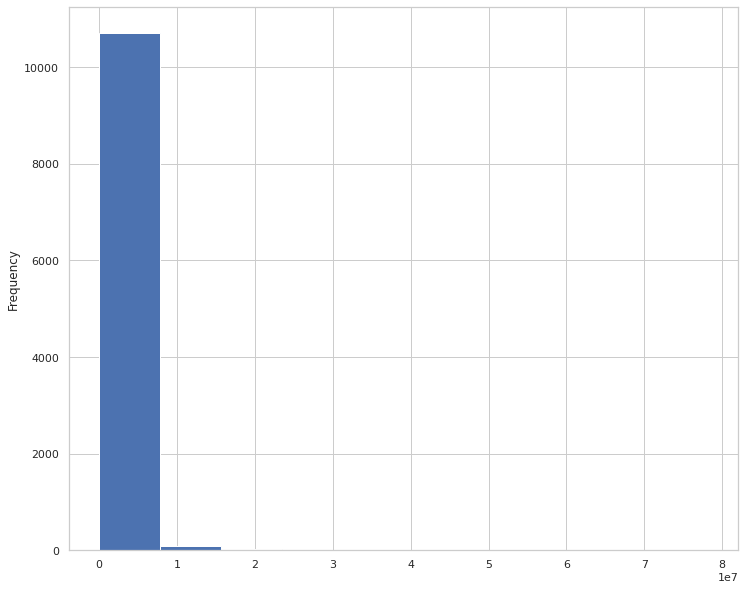

In [116]:
df['Reviews'].loc[df['Reviews'] != '3.0M'].astype(float).plot(kind='hist')
plt.show()

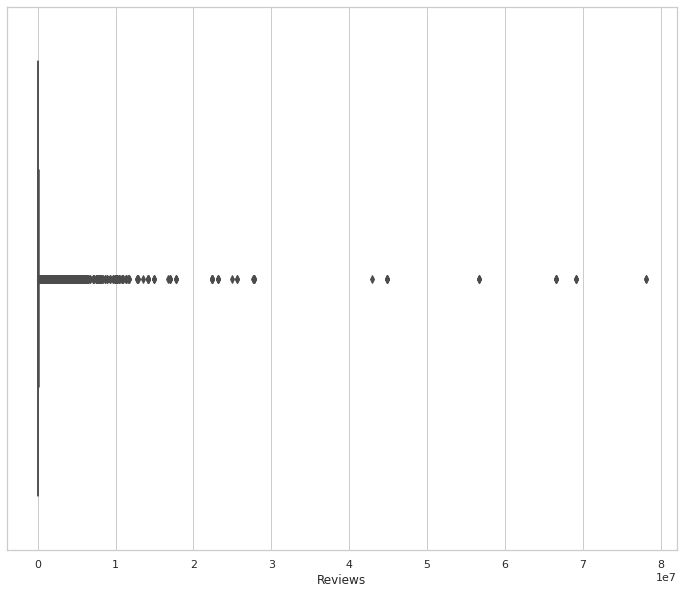

In [117]:
sns.boxplot(x=df['Reviews'].loc[df['Reviews'] != '3.0M'].astype(float))
plt.show()

This column has a very strong right skewness. We'll apply a log transform.

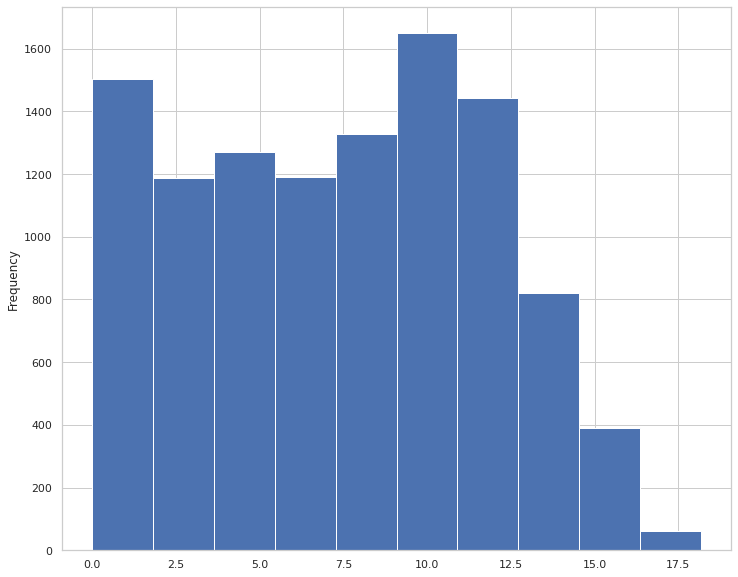

In [118]:
np.log1p(df['Reviews'].loc[df['Reviews'] != '3.0M'].astype(float)).plot(kind='hist')
plt.show()

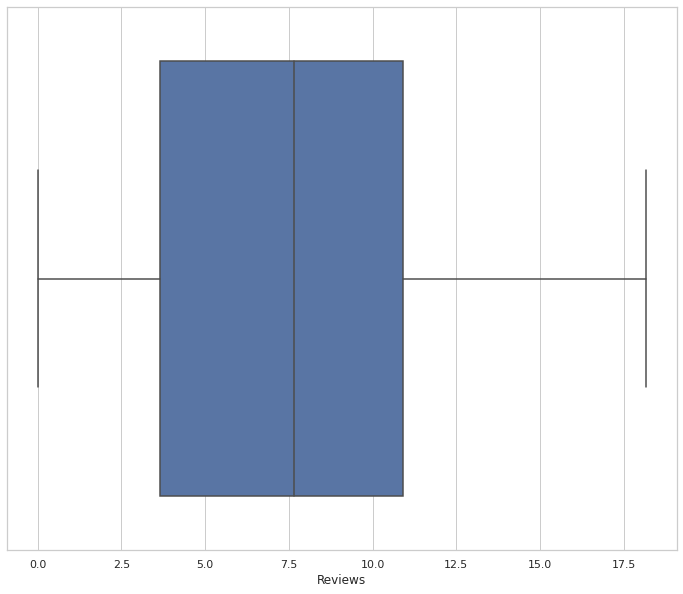

In [119]:
ax = sns.boxplot(x=np.log1p(df['Reviews'].loc[df['Reviews'] != '3.0M'].astype(float)))

### Investigate the `Installs` column

In [120]:
df['Installs']

0            10,000+
1           500,000+
2         5,000,000+
3        50,000,000+
4           100,000+
            ...     
10836         5,000+
10837           100+
10838         1,000+
10839         1,000+
10840    10,000,000+
Name: Installs, Length: 10841, dtype: object

In [121]:
df['Installs'].replace('[^0-9]','', regex=True)

0           10000
1          500000
2         5000000
3        50000000
4          100000
           ...   
10836        5000
10837         100
10838        1000
10839        1000
10840    10000000
Name: Installs, Length: 10841, dtype: object

In [122]:
df.loc[df['Installs'].replace('[^0-9]','', regex=True).apply(lambda x: np.NaN if not x.isnumeric() else x).isna()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


This is again the row that will be removed.

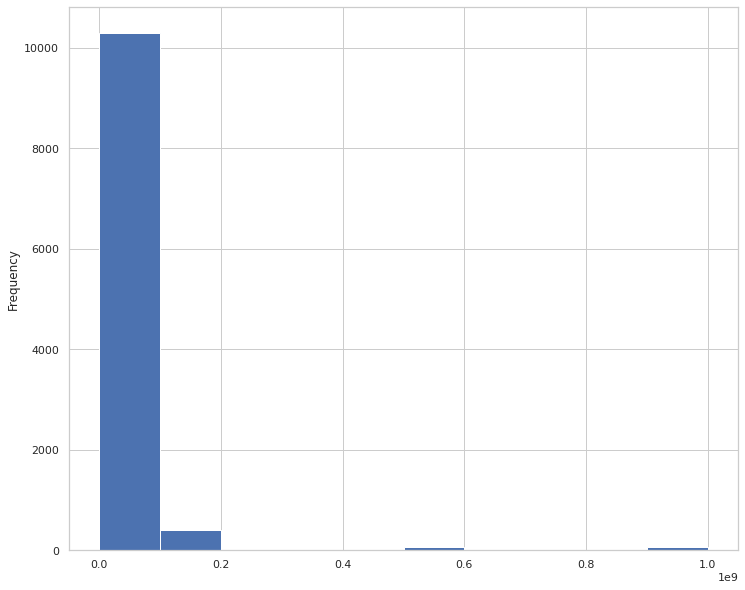

In [123]:
df['Installs'].replace('[^0-9]','', regex=True).apply(lambda x: np.NaN if not x.isnumeric() else x).astype(float).plot(kind='hist')
plt.show()

A log transform is also needed here.

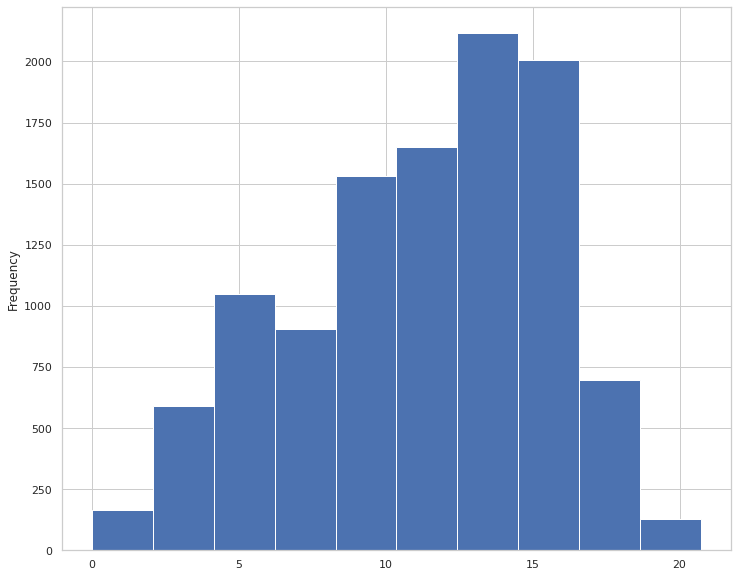

In [124]:
np.log1p(df['Installs'].replace('[^0-9]','', regex=True).apply(lambda x: np.NaN if not x.isnumeric() else x).astype(float)).plot(kind='hist')
plt.show()

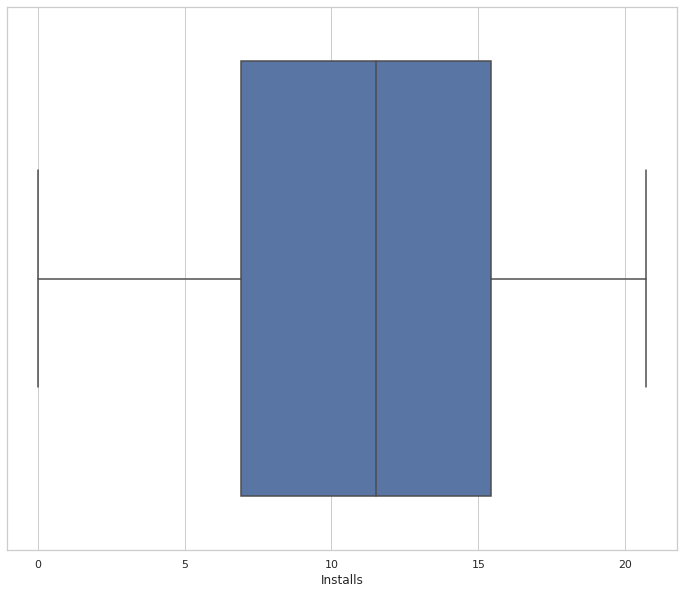

In [125]:
ax = sns.boxplot(x=np.log1p(df['Installs'].replace('[^0-9]','', regex=True).apply(lambda x: np.NaN if not x.isnumeric() else x).astype(float)))

Let's save a copy of the dataframe that excludes the invalid row.

In [126]:
valid_df = df.iloc[~df['Price'].index.isin(INVALID_ROW_IDXS)]
valid_df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


### Investigate the `Price` column

In [127]:
valid_df['Price'].replace('[^0-9]', '', regex=True).astype(float)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
10836    0.0
10837    0.0
10838    0.0
10839    0.0
10840    0.0
Name: Price, Length: 10840, dtype: float64

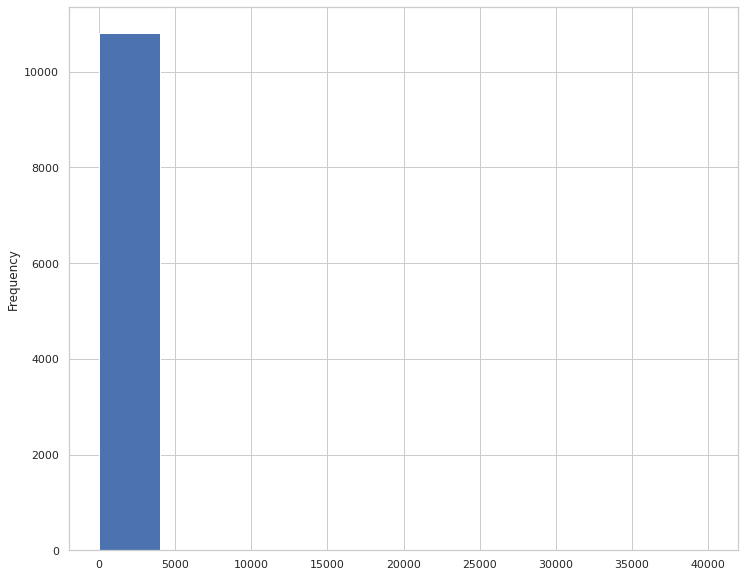

In [128]:
valid_df['Price'].replace('[^0-9]', '', regex=True).astype(float).plot(kind='hist')
plt.show()

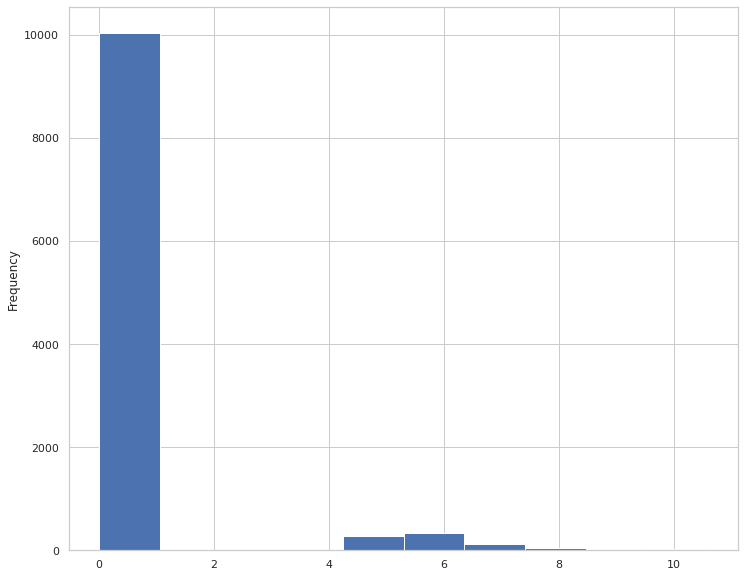

In [129]:
np.log1p(valid_df['Price'].replace('[^0-9]', '', regex=True).astype(float)).plot(kind='hist')
plt.show()

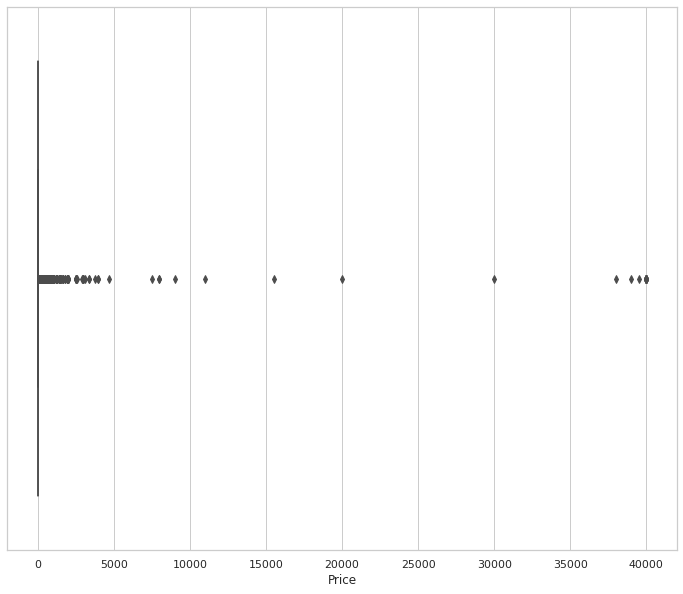

In [130]:
ax = sns.boxplot(x=valid_df['Price'].replace('[^0-9]', '', regex=True).astype(float))

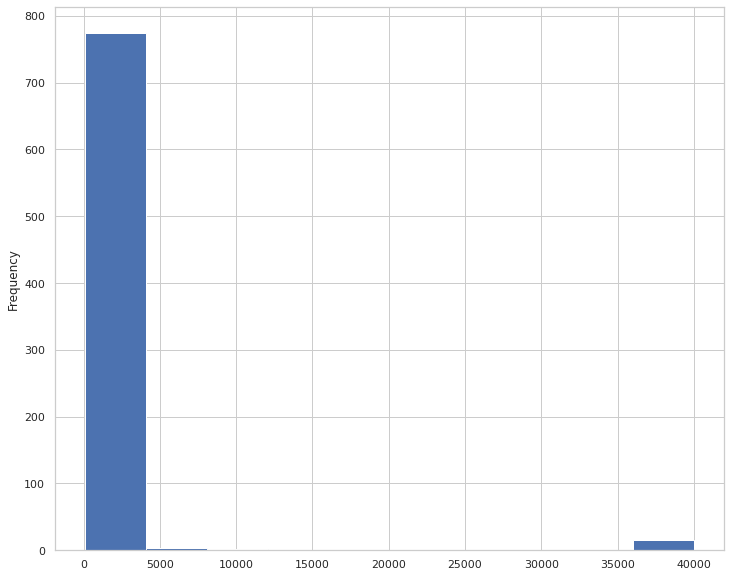

In [131]:
tmp = valid_df['Price'].replace('[^0-9]', '', regex=True).astype(float)
tmp[tmp > 0].plot(kind='hist')
plt.show()

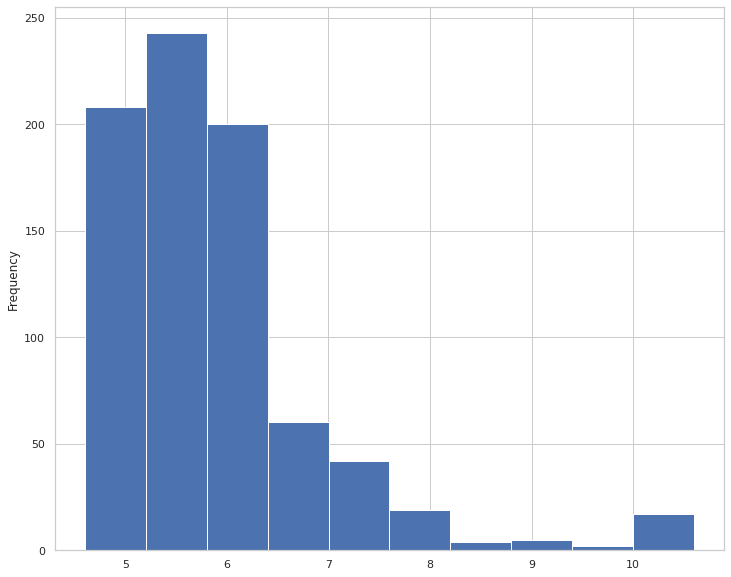

In [132]:
np.log1p(tmp[tmp > 0]).plot(kind='hist')
plt.show()

In [133]:
np.log1p(tmp[tmp > 0]).skew()

1.7722041760191496

The skewness is too much so we better remove this column.

### Investigate the `Size` column

In [134]:
valid_df['Size'].apply(lambda x : x[-1]).value_counts()

M    8829
e    1695
k     316
Name: Size, dtype: int64

In [135]:
valid_df[valid_df['Size'].str[-1] == 'e']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
37,Floor Plan Creator,ART_AND_DESIGN,4.1,36639,Varies with device,"5,000,000+",Free,0,Everyone,Art & Design,"July 14, 2018",Varies with device,2.3.3 and up
42,Textgram - write on photos,ART_AND_DESIGN,4.4,295221,Varies with device,"10,000,000+",Free,0,Everyone,Art & Design,"July 30, 2018",Varies with device,Varies with device
52,Used Cars and Trucks for Sale,AUTO_AND_VEHICLES,4.6,17057,Varies with device,"1,000,000+",Free,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device
67,Ulysse Speedometer,AUTO_AND_VEHICLES,4.3,40211,Varies with device,"5,000,000+",Free,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device
68,REPUVE,AUTO_AND_VEHICLES,3.9,356,Varies with device,"100,000+",Free,0,Everyone,Auto & Vehicles,"May 25, 2018",Varies with device,Varies with device
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10713,My Earthquake Alerts - US & Worldwide Earthquakes,WEATHER,4.4,3471,Varies with device,"100,000+",Free,0,Everyone,Weather,"July 24, 2018",Varies with device,Varies with device
10725,Posta App,MAPS_AND_NAVIGATION,3.6,8,Varies with device,"1,000+",Free,0,Everyone,Maps & Navigation,"September 27, 2017",Varies with device,4.4 and up
10765,Chat For Strangers - Video Chat,SOCIAL,3.4,622,Varies with device,"100,000+",Free,0,Mature 17+,Social,"May 23, 2018",Varies with device,Varies with device
10826,Frim: get new friends on local chat rooms,SOCIAL,4.0,88486,Varies with device,"5,000,000+",Free,0,Mature 17+,Social,"March 23, 2018",Varies with device,Varies with device


We'll convert everything to **kilobytes**. We'll impute everything with `Varies with device` with the mean or mode of the column.

In [136]:
tmp = valid_df['Size'].apply(lambda x : float(x[:-1]) * 1000 if x[-1] == 'M' else x)
tmp

0                   19000.0
1                   14000.0
2                    8700.0
3                   25000.0
4                    2800.0
                ...        
10836               53000.0
10837                3600.0
10838                9500.0
10839    Varies with device
10840               19000.0
Name: Size, Length: 10840, dtype: object

In [137]:
tmp.apply(lambda x: str(x)[-1]).value_counts()

0    8829
e    1695
k     316
Name: Size, dtype: int64

In [138]:
tmp = tmp.apply(lambda x : float(str(x)[:-1]) if str(x)[-1] == 'k' else x)
tmp

0                   19000.0
1                   14000.0
2                    8700.0
3                   25000.0
4                    2800.0
                ...        
10836               53000.0
10837                3600.0
10838                9500.0
10839    Varies with device
10840               19000.0
Name: Size, Length: 10840, dtype: object

In [139]:
tmp.apply(lambda x: str(x)[-1]).value_counts()

0    9144
e    1695
5       1
Name: Size, dtype: int64

In [140]:
tmp = tmp.apply(lambda x : np.NaN if str(x)[-1] == 'e' else x)
tmp

0        19000.0
1        14000.0
2         8700.0
3        25000.0
4         2800.0
          ...   
10836    53000.0
10837     3600.0
10838     9500.0
10839        NaN
10840    19000.0
Name: Size, Length: 10840, dtype: float64

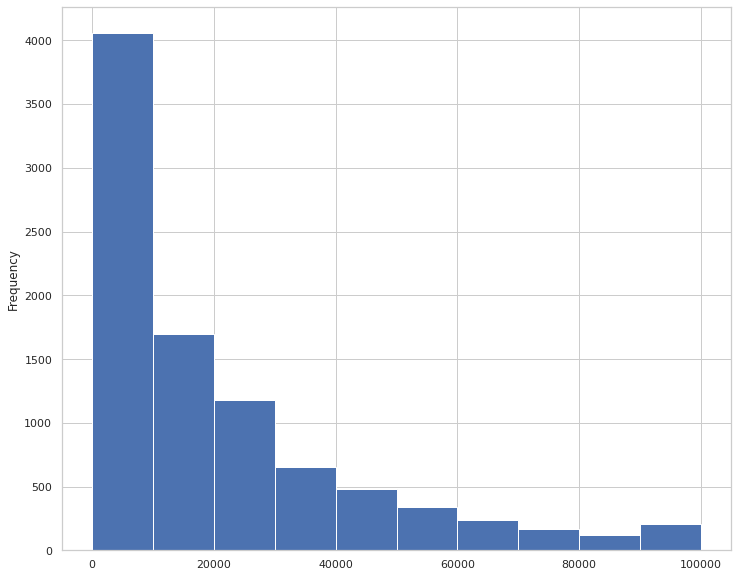

In [141]:
tmp.plot(kind='hist')
plt.show()

We have right skewness. Let's try a log transform.

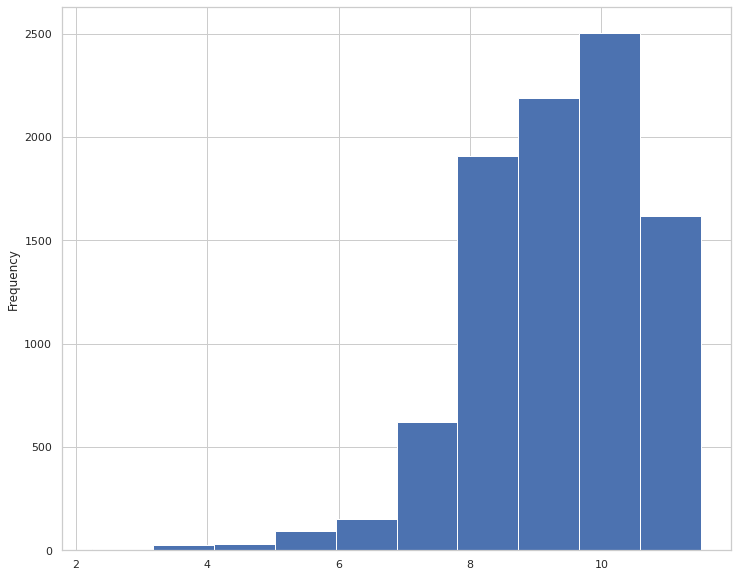

In [142]:
np.log1p(tmp).plot(kind='hist')
plt.show()

In [143]:
tmp.skew(), np.log1p(tmp).skew()

(1.5573779573590947, -0.831933400303106)

In [144]:
tmp.describe()

count      9145.000000
mean      21516.529524
std       22588.747934
min           8.500000
25%        4900.000000
50%       13000.000000
75%       30000.000000
max      100000.000000
Name: Size, dtype: float64

In [145]:
np.log1p(tmp).describe()

count    9145.000000
mean        9.345544
std         1.294441
min         2.251292
25%         8.497195
50%         9.472782
75%        10.308986
max        11.512935
Name: Size, dtype: float64

The column has a very large variance. Although the log transform didn't really help with the skewness, it reduced the variance by a lot so we'll use it.

### Investigate the `Last Updated` column

In [146]:
pd.to_datetime(valid_df['Last Updated']).apply(lambda x: x.year)

0        2018
1        2018
2        2018
3        2018
4        2018
         ... 
10836    2017
10837    2018
10838    2017
10839    2015
10840    2018
Name: Last Updated, Length: 10840, dtype: int64

### Investigate the `Current Ver` column

In [147]:
valid_df['Current Ver'].apply(lambda x: str(x).split('.')[0]).unique()

array(['1', '2', 'Varies with device', '6', '3', 'nan', '5', '4', '11',
       '0', '8', '10', '18', '9', '15', '14', '7', '99', '12', '37', '24',
       '47', 'R6', '69', '42', '196', '2018', '20', '13', 'v1', '01',
       '43', '16', 'Cannonau 3', 'p5', '112', 'Public', '220', '858',
       'v3', 'Version:6', '02', '3196', '5423', '19', '1_39_93', '79',
       '108', '57', '60', '149', '37893', '20180609', '28', '25',
       '300000', 'PN', 'Initial', 'T4', '50', '27', '29', '584', '22',
       '71', '1004', '06', '2017', '17', '53', 'v5', 'MyMetro_HTML_2',
       'v8', 'v7', '32', '20180517', 'v150', '40', '68',
       'FreeTimeApp-aosp_v3', 'Natalia Studio Development', '30', '116',
       '04', '27500000', 'version 0', '5055', 'a', '31', '1009001',
       '1900001', 'v8[1', '23', '1805', '1,01', 'v2018', 'H7SubTV0', 'v2',
       '263', '65', 'acremotecontrol18', 'v67_slk3',
       'airConditionerMaintenance_13112015', '11;11',
       'acremotecontrol-v7', '1255162018', 'v4', '117'

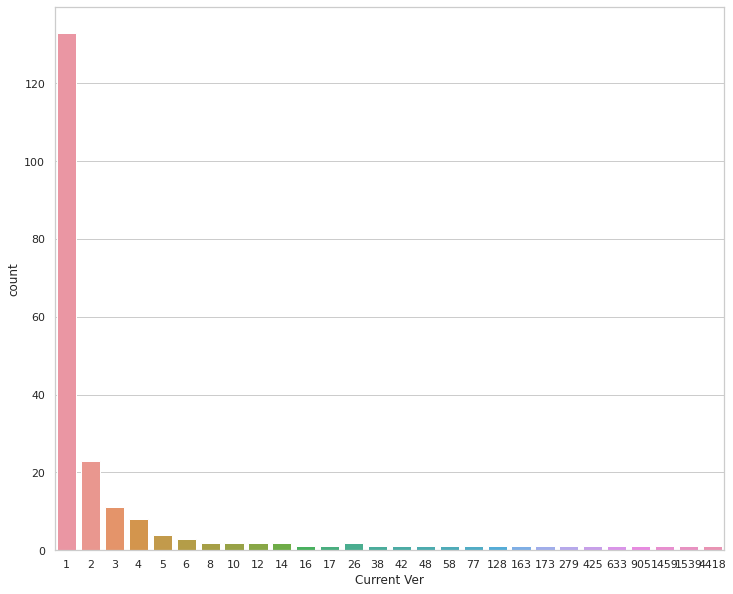

In [148]:
ax = sns.countplot(x=valid_df['Current Ver'].apply(lambda x: str(x).split('.')[0]).value_counts())

We don't have much data for the version column. There are a lot of strange values. We'll drop it as it's unlikely to be that helpful.

### Investigate the `Android Ver` column

In [149]:
tmp = valid_df['Android Ver'].apply(lambda x: str(x).split('.')[0])
tmp.value_counts()

4                     6959
Varies with device    1362
2                     1351
5                      629
3                      287
1                      138
6                       60
7                       46
8                        6
nan                      2
Name: Android Ver, dtype: int64

In [150]:
valid_df.iloc[tmp[tmp == 'nan'].index]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
4453,[substratum] Vacuum: P,PERSONALIZATION,4.4,230,11M,"1,000+",Paid,$1.49,Everyone,Personalization,"July 20, 2018",4.4,NaN
4490,Pi Dark [substratum],PERSONALIZATION,4.5,189,2.1M,"10,000+",Free,0,Everyone,Personalization,"March 27, 2018",1.1,NaN


The `Andrioid Ver` column, unlike the `Current Ver` column, might be helpful, so we'll keep it. We'll impute the `NaN`s and the `Varies with device` entries with the mode of the column.

In [151]:
tmp[(tmp == 'Varies with device') | (tmp == 'nan')] = np.NaN
tmp.unique()

array(['4', '2', '3', nan, '5', '6', '1', '7', '8'], dtype=object)

In [152]:
tmp.isna().mean()

0.12583025830258301

12% of the values are missing, so we can impute them

In [153]:
tmp.mode()[0]

'4'

### Investigate the `Type` column

In [154]:
tmp = valid_df['Type']
tmp

0        Free
1        Free
2        Free
3        Free
4        Free
         ... 
10836    Free
10837    Free
10838    Free
10839    Free
10840    Free
Name: Type, Length: 10840, dtype: object

In [155]:
tmp.unique()

array(['Free', 'Paid', nan], dtype=object)

In [156]:
tmp.isna().sum()

1

In [157]:
valid_df[tmp.isna()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
9148,Command & Conquer: Rivals,FAMILY,NaN,0,Varies with device,0,NaN,0,Everyone 10+,Strategy,"June 28, 2018",Varies with device,Varies with device


This row has too many missing features - we'll remove it.

In [158]:
INVALID_ROW_IDXS.append(9148)

### Investigate the `Rating` column

In [159]:
tmp = valid_df['Rating'].copy()
tmp

0        4.1
1        3.9
2        4.7
3        4.5
4        4.3
        ... 
10836    4.5
10837    5.0
10838    NaN
10839    4.5
10840    4.5
Name: Rating, Length: 10840, dtype: float64

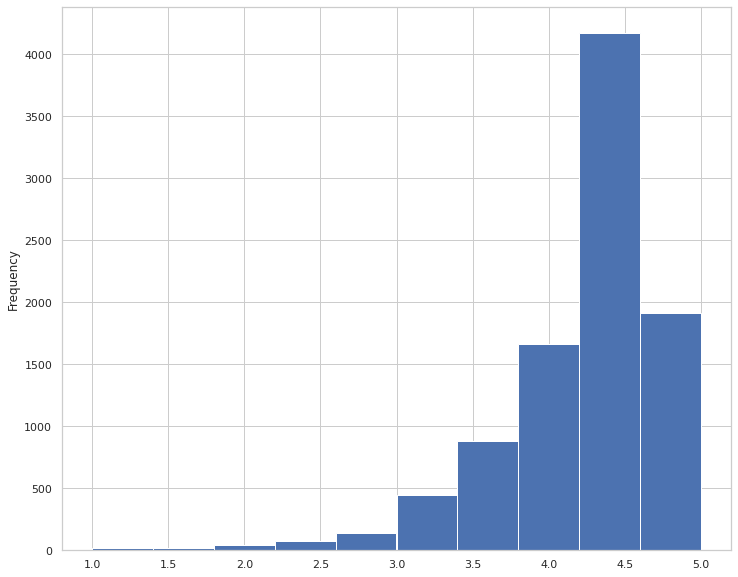

In [160]:
tmp.plot(kind='hist')
plt.show()

Since this is left skewed a log transform won't help much.

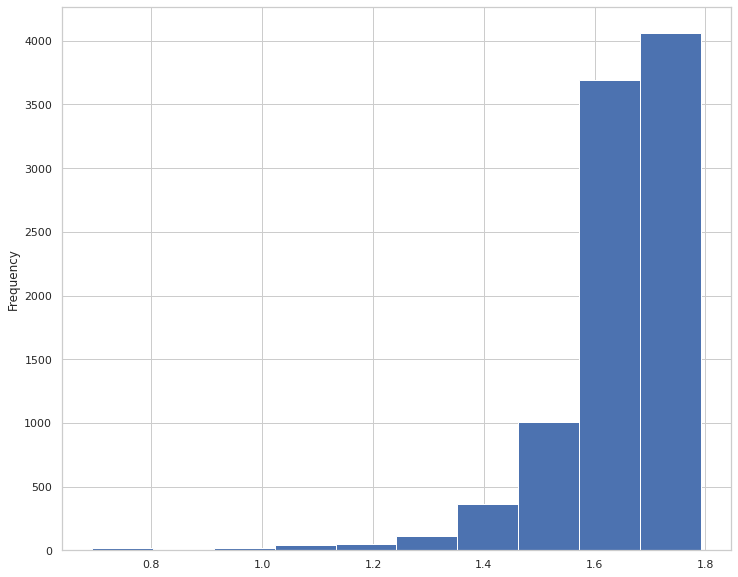

In [161]:
np.log1p(tmp).plot(kind='hist')
plt.show()

In [162]:
tmp.skew(), np.log1p(tmp).skew()

(-1.8496951283704521, -2.878787091411616)

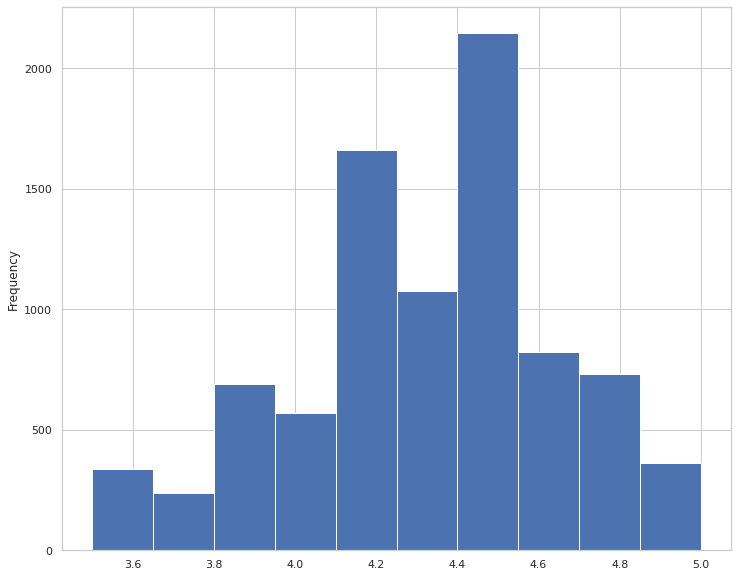

In [163]:
tmp[tmp > 3.4].plot(kind='hist')
plt.show()

## Preprocessing

In [164]:
def convert_size_col(col_as_series):
    col_as_series = col_as_series.copy()
    
    col_as_series = col_as_series.apply(lambda x : float(x[:-1]) * 1000 if x[-1] == 'M' else x)
    col_as_series = col_as_series.apply(lambda x : float(str(x)[:-1]) if str(x)[-1] == 'k' else x)
    col_as_series = col_as_series.apply(lambda x : np.NaN if str(x)[-1] == 'e' else x)
    
    return col_as_series

def encode(df):
    df = df.copy()
    
    for col in df.select_dtypes('object').columns:
        if len(df[col].unique()) == 2:
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col, drop_first=True)], axis=1)
        else:
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
            
        df = df.drop(col, axis=1)
    
    return df
    
def preprocess_inputs(df, clean_only=False, ret_X_y=False, rem_outliers=False, keep_genres=True):
    df = df.copy()
    
    # Drop high-cardinality 'App' column, `Price` column, and `Current Ver` column.
    df = df.drop(['App', 'Price', 'Current Ver'], axis=1)
    
    # Drop rows with invalid data
    df = df.drop(INVALID_ROW_IDXS)
        
    # Convert the `Reviews` column to float
    df['Reviews'] = np.log1p(df['Reviews'].astype(float))

    # Convert the `Installs` column to float
    df['Installs'] = df['Installs'].replace('[^0-9]','', regex=True)    
    df['Installs'] = np.log1p(df['Installs'].astype(float))

    # Convert the `Size` column to float
    df['Size'] = convert_size_col(df['Size'])
    df['Size'] = np.log1p(df['Size'])
    df['Size'] = df['Size'].fillna(df['Size'].mean())

    # Extract the year, month, and day from the `Last Updated` column
    df['Last Updated Year'] = pd.to_datetime(df['Last Updated']).apply(lambda x: x.year)
    df['Last Updated Month'] = pd.to_datetime(df['Last Updated']).apply(lambda x: x.month)
    df['Last Updated Day'] = pd.to_datetime(df['Last Updated']).apply(lambda x: x.day)
    df = df.drop(['Last Updated'], axis=1)

    # For the `Android Ver` column take only the major version.
    df['Android Ver'] = df['Android Ver'].apply(lambda x: str(x).split('.')[0])
    df['Android Ver'] = df['Android Ver'].apply(lambda x: np.NaN if str(x) in ['Varies with device', 'nan'] else x)
    df['Android Ver'] = df['Android Ver'].fillna(df['Android Ver'].mode()[0])
    df['Android Ver'] = df['Android Ver'].astype(int)

    # Remove outliers
    if rem_outliers:
        df['Rating'] = df.loc[df['Rating'] > 3.4, ['Rating']]
        df['Size'] = df.loc[df['Size'] > 7, 'Size']
    
    # Remove `Genres`
    if not keep_genres:
        df = df.drop(['Genres'], axis=1)
    
    # Impute values for `Rating` column.
    df['Rating'] = df['Rating'].fillna(df['Rating'].mode()[0])
    df['Size'] = df['Size'].fillna(df['Size'].mean())
    
    if clean_only:
        return df
    
    y = df['Type'].replace({'Paid': 1, 'Free': 0})
    X = encode(df.drop(['Type'], axis=1))
    
    numeric_cols = df.select_dtypes('number').columns
    
    scaler = StandardScaler()
    
    if ret_X_y:
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
        return X, y
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    scaler.fit(X_train[numeric_cols])
    X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
    
    return X_train, X_test, y_train, y_test

In [165]:
df_p = preprocess_inputs(df, clean_only=True)
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10839 entries, 0 to 10840
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Category            10839 non-null  object 
 1   Rating              10839 non-null  float64
 2   Reviews             10839 non-null  float64
 3   Size                10839 non-null  float64
 4   Installs            10839 non-null  float64
 5   Type                10839 non-null  object 
 6   Content Rating      10839 non-null  object 
 7   Genres              10839 non-null  object 
 8   Android Ver         10839 non-null  int64  
 9   Last Updated Year   10839 non-null  int64  
 10  Last Updated Month  10839 non-null  int64  
 11  Last Updated Day    10839 non-null  int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 1.1+ MB


In [166]:
df_p.describe()

,Rating,Reviews,Size,Installs,Android Ver,Last Updated Year,Last Updated Month,Last Updated Day
count,10839.000000,10839.000000,10839.000000,10839.000000,10839.000000,10839.000000,10839.000000,10839.000000
mean,4.220057,7.395748,9.345544,11.250242,3.770089,2017.399668,6.422364,15.607897
std,0.484217,4.381293,1.188984,4.525805,0.845025,1.100950,2.578504,9.561321
min,1.000000,0.000000,2.251292,0.000000,1.000000,2010.000000,1.000000,1.000000
25%,4.100000,3.663562,8.682877,7.713074,4.000000,2017.000000,5.000000,6.000000
50%,4.400000,7.647309,9.345544,11.512935,4.000000,2018.000000,7.000000,16.000000
75%,4.500000,10.911153,10.165890,15.424949,4.000000,2018.000000,8.000000,24.000000
max,5.000000,18.174247,11.512935,20.723266,8.000000,2018.000000,12.000000,31.000000


In [167]:
print_uniques(df_p.select_dtypes('object'))

Category        | object  |   33 |  0.00 | 
Type            | object  |    2 |  0.00 | ['Free' 'Paid']
Content Rating  | object  |    6 |  0.00 | ['Everyone' 'Teen' 'Everyone 10+' 'Mature 17+' 'Adults only 18+' 'Unrated']
Genres          | object  |  119 |  0.01 | 


The `Category` and `Genres` columns might have a high correlation. In other words, it's not guaranteed that `Genres` is adding more information. We should experiment with it.

In [168]:
df_p.head()

,Category,Rating,Reviews,Size,Installs,Type,Content Rating,Genres,Android Ver,Last Updated Year,Last Updated Month,Last Updated Day
0,ART_AND_DESIGN,4.1,5.075174,9.852247,9.210440,Free,Everyone,Art & Design,4,2018,1,7
1,ART_AND_DESIGN,3.9,6.875232,9.546884,13.122365,Free,Everyone,Art & Design;Pretend Play,4,2018,1,15
2,ART_AND_DESIGN,4.7,11.379520,9.071193,15.424949,Free,Everyone,Art & Design,4,2018,8,1
3,ART_AND_DESIGN,4.5,12.281389,10.126671,17.727534,Free,Teen,Art & Design,4,2018,6,8
4,ART_AND_DESIGN,4.3,6.875232,7.937732,11.512935,Free,Everyone,Art & Design;Creativity,4,2018,6,20


In [169]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10839 entries, 0 to 10840
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Category            10839 non-null  object 
 1   Rating              10839 non-null  float64
 2   Reviews             10839 non-null  float64
 3   Size                10839 non-null  float64
 4   Installs            10839 non-null  float64
 5   Type                10839 non-null  object 
 6   Content Rating      10839 non-null  object 
 7   Genres              10839 non-null  object 
 8   Android Ver         10839 non-null  int64  
 9   Last Updated Year   10839 non-null  int64  
 10  Last Updated Month  10839 non-null  int64  
 11  Last Updated Day    10839 non-null  int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 1.1+ MB


In [170]:
df_p.isna().mean()

Category              0.0
Rating                0.0
Reviews               0.0
Size                  0.0
Installs              0.0
Type                  0.0
Content Rating        0.0
Genres                0.0
Android Ver           0.0
Last Updated Year     0.0
Last Updated Month    0.0
Last Updated Day      0.0
dtype: float64

In [171]:
df_p.describe()

,Rating,Reviews,Size,Installs,Android Ver,Last Updated Year,Last Updated Month,Last Updated Day
count,10839.000000,10839.000000,10839.000000,10839.000000,10839.000000,10839.000000,10839.000000,10839.000000
mean,4.220057,7.395748,9.345544,11.250242,3.770089,2017.399668,6.422364,15.607897
std,0.484217,4.381293,1.188984,4.525805,0.845025,1.100950,2.578504,9.561321
min,1.000000,0.000000,2.251292,0.000000,1.000000,2010.000000,1.000000,1.000000
25%,4.100000,3.663562,8.682877,7.713074,4.000000,2017.000000,5.000000,6.000000
50%,4.400000,7.647309,9.345544,11.512935,4.000000,2018.000000,7.000000,16.000000
75%,4.500000,10.911153,10.165890,15.424949,4.000000,2018.000000,8.000000,24.000000
max,5.000000,18.174247,11.512935,20.723266,8.000000,2018.000000,12.000000,31.000000


In [172]:
df_p.describe(include=object)

,Category,Type,Content Rating,Genres
count,10839,10839,10839,10839
unique,33,2,6,119
top,FAMILY,Free,Everyone,Tools
freq,1971,10039,8714,842


## Exploratory Data Analysis

### Which is the most popular category?

This questions can be answered in two ways:

- Which category is most popular with developers (has the most applications is itself)?
- Which category is most popular with users (has the most installs)?

#### Which category is most popular with developers (has the most applications is itself)?

In [173]:
df_p['Category'].value_counts(normalize=True)

FAMILY                 0.181843
GAME                   0.105545
TOOLS                  0.077775
MEDICAL                0.042716
BUSINESS               0.042439
PRODUCTIVITY           0.039118
PERSONALIZATION        0.036166
COMMUNICATION          0.035704
SPORTS                 0.035428
LIFESTYLE              0.035243
FINANCE                0.033767
HEALTH_AND_FITNESS     0.031460
PHOTOGRAPHY            0.030907
SOCIAL                 0.027217
NEWS_AND_MAGAZINES     0.026109
SHOPPING               0.023987
TRAVEL_AND_LOCAL       0.023803
DATING                 0.021589
BOOKS_AND_REFERENCE    0.021312
VIDEO_PLAYERS          0.016145
EDUCATION              0.014392
ENTERTAINMENT          0.013747
MAPS_AND_NAVIGATION    0.012640
FOOD_AND_DRINK         0.011717
HOUSE_AND_HOME         0.008119
AUTO_AND_VEHICLES      0.007842
LIBRARIES_AND_DEMO     0.007842
WEATHER                0.007565
ART_AND_DESIGN         0.005997
EVENTS                 0.005905
PARENTING              0.005536
COMICS  

The `Family` category is the category that is most popular with developers. Almost 20% of all apps are in this category.

#### Which category is most popular with users (has the most installs)?

In [174]:
df_p[['Category', 'Installs']].groupby(by=['Category']).agg(['count'])

,Installs
,count
Category,
ART_AND_DESIGN,65
AUTO_AND_VEHICLES,85
BEAUTY,53
BOOKS_AND_REFERENCE,231
BUSINESS,460
COMICS,60
COMMUNICATION,387
DATING,234


In [175]:
df_p[['Category', 'Installs']].groupby(by=['Category']).agg(['count']).columns

MultiIndex([('Installs', 'count')],
           )

In [176]:
df_p[['Category', 'Installs']] \
    .groupby(by=['Category']) \
    .agg(['count']) \
    .sort_values(by=[('Installs', 'count')], ascending=False)

,Installs
,count
Category,
FAMILY,1971
GAME,1144
TOOLS,843
MEDICAL,463
BUSINESS,460
PRODUCTIVITY,424
PERSONALIZATION,392
COMMUNICATION,387


Maybe not unexpected, but the `Family` category is the most popular category amoung users as well.

### What is the average rating that an app gets?

In [177]:
df_p['Rating'].mean()

4.220057200848978

The **average rating is 4.2-4.3 / 5**. I expected it to be lower.

**Note**: We can see this from the `describe` method as well.

### What rating determines a successful app?

The answer largely depends on what we consider a `successful` application to be. If we agree that a successful application has at least 10 installs (on the logarithmic scale), let's find out what the average rating is and anything higher that it, would be our answer.

In [178]:
grouped = df_p[['Rating', 'Installs']].groupby(by=['Installs']).agg('mean')
grouped

,Rating
Installs,
0.000000,4.400000
0.693147,4.426866
1.791759,4.423171
2.397895,4.440155
3.931826,4.405366
4.615121,4.384284
6.216606,4.263939
6.908755,4.138037
8.517393,4.059958


In [179]:
grouped[grouped.index > 10].mean()

Rating    4.249258
dtype: float64

Maybe it was clear from the previous question, but yes - anything above 4.2 (the average rating) should be consider a success. In other words, you're above average.

### Should the application be free?

In [180]:
df_p[['Type', 'Installs']].groupby(by=['Type']).agg('mean')

,Installs
Type,
Free,11.563407
Paid,7.320419


If we want to have more installations then it should be free.

### Which social group should be targeted?

This question can also be answered in two ways:

- Which social group installs the most apps?
- Which social group installs the most paid apps?

#### Which social group installs the most apps?

In [181]:
df_p[['Content Rating', 'Installs']] \
    .groupby(by='Content Rating') \
    .agg('sum') \
    .sort_values(by='Installs', ascending=False)

,Installs
Content Rating,
Everyone,94987.711772
Teen,15159.876230
Mature 17+,6076.958714
Everyone 10+,5659.730045
Adults only 18+,40.060242
Unrated,17.036404


In [182]:
df_p[['Content Rating', 'Installs']] \
    .groupby(by='Content Rating') \
    .agg('mean') \
    .sort_values(by='Installs', ascending=False)

,Installs
Content Rating,
Everyone 10+,13.703947
Adults only 18+,13.353414
Teen,12.549566
Mature 17+,12.178274
Everyone,10.900587
Unrated,8.518202


Although the `Everyone` group has the most installs, on average a person in the `Everyone 10+` has more installs than a person in the `Everyone` group. Let's see them.

In [183]:
df_p.loc[df_p['Content Rating'] == 'Everyone', 'Installs'].mean()

10.900586616003228

In [184]:
df_p.loc[df_p['Content Rating'] == 'Everyone 10+', 'Installs'].mean()

13.703946840210902

#### Which social group installs mostly paid apps?

In [185]:
df_p.loc[df_p['Type'] == 'Paid', ['Content Rating', 'Installs', 'Type']]

,Content Rating,Installs,Type
234,Everyone,11.512935,Paid
235,Everyone,11.512935,Paid
290,Everyone,11.512935,Paid
291,Everyone,11.512935,Paid
427,Everyone,11.512935,Paid
...,...,...,...
10735,Mature 17+,4.615121,Paid
10760,Everyone,6.908755,Paid
10782,Teen,9.210440,Paid
10785,Everyone,9.210440,Paid


In [186]:
df_p.loc[df_p['Type'] == 'Paid', ['Content Rating', 'Installs']] \
    .groupby(by=['Content Rating']) \
    .agg('mean') \
    .sort_values(by='Installs', ascending=False)

,Installs
Content Rating,
Everyone 10+,10.410272
Teen,8.571230
Mature 17+,8.128172
Everyone,7.056875


On average the `Everyone 10+` group installs mostly paid apps. We ought to target it.

### Plots

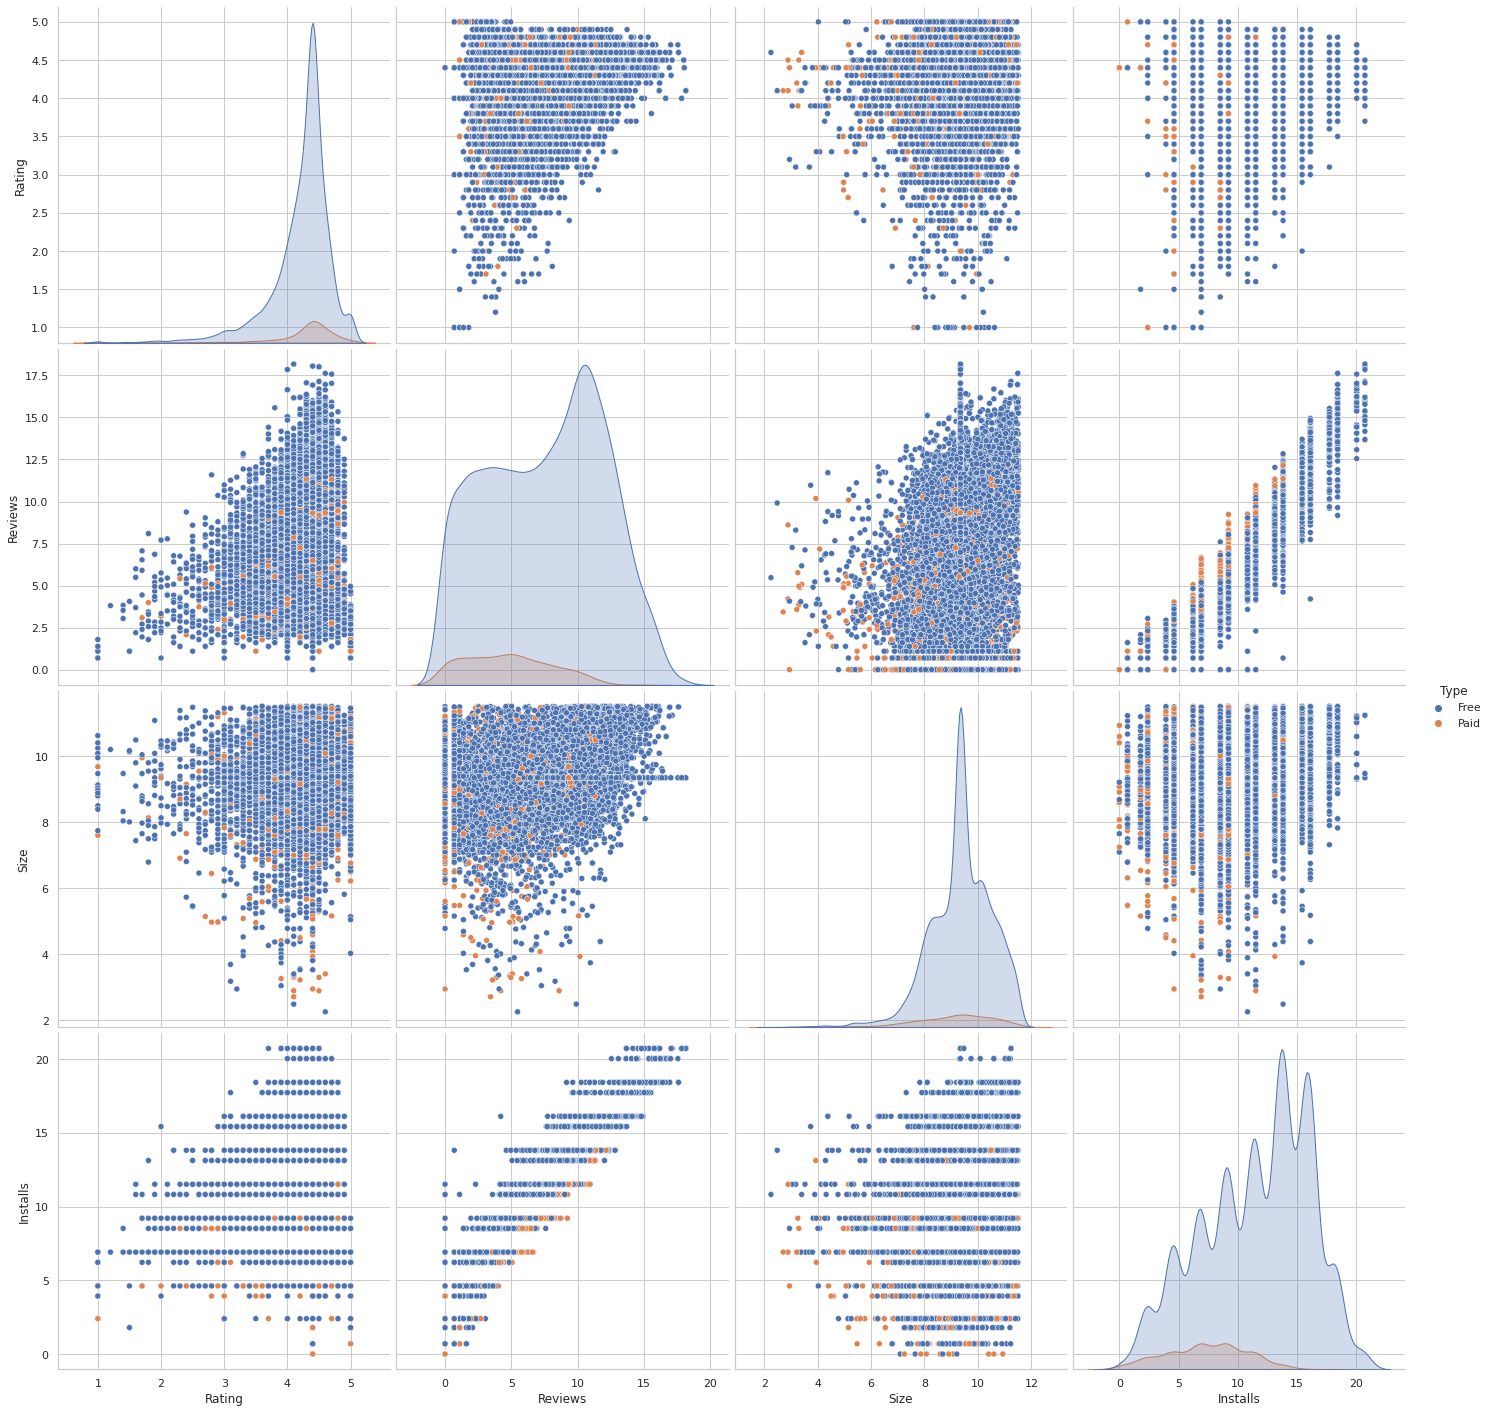

In [187]:
ax = sns.pairplot(df_p[['Rating', 'Reviews', 'Size', 'Installs', 'Type']], hue='Type', height=5)

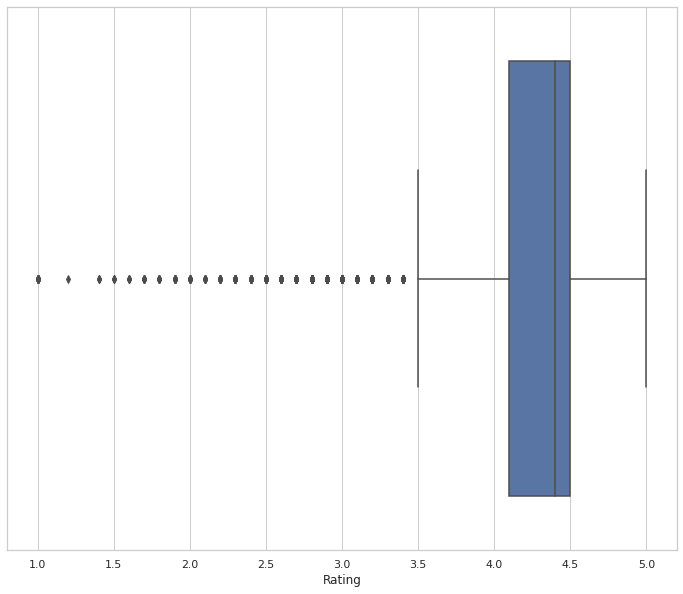

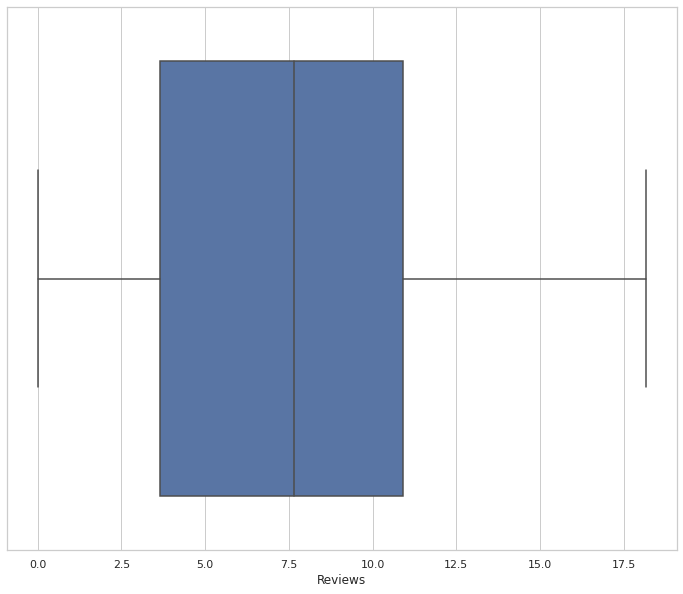

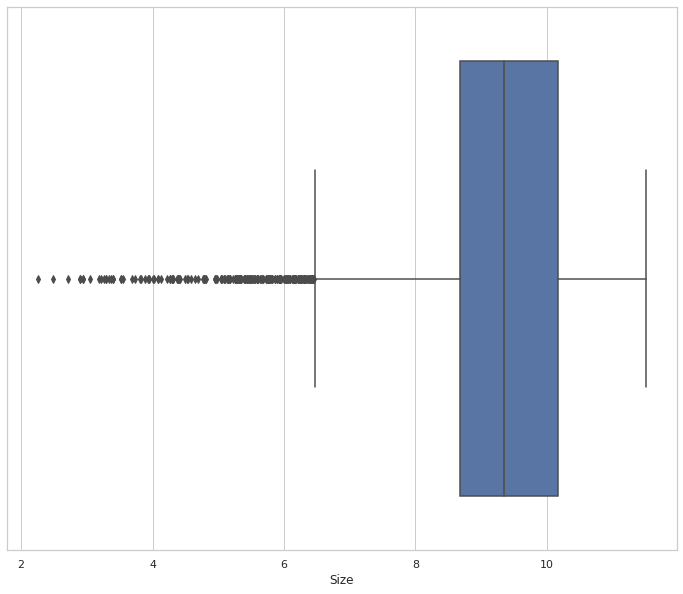

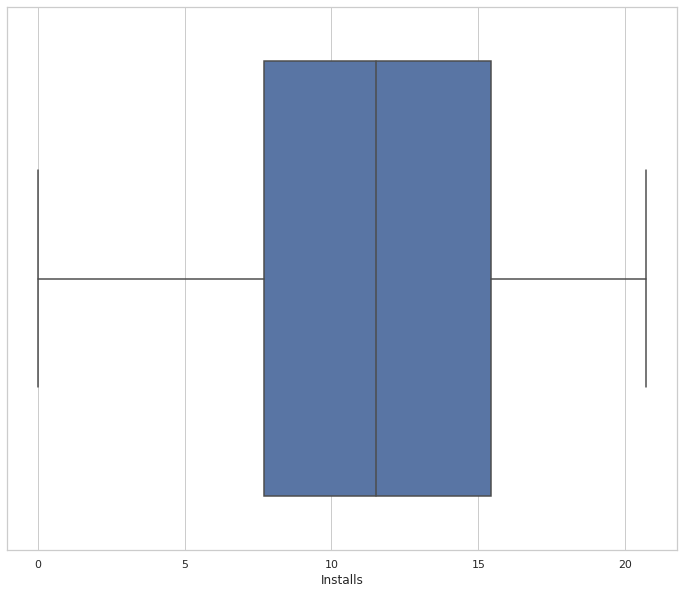

In [188]:
for col in ['Rating', 'Reviews', 'Size', 'Installs']:
    plt.figure()
    ax = sns.boxplot(x=df_p[col])

#### Outliers

We see that `Rating` and `Size` have outliers. We should experiment with keeping them.

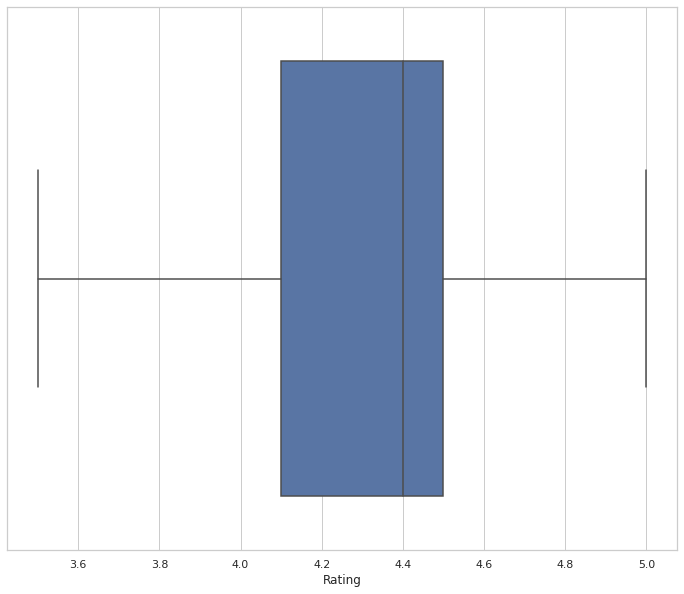

In [189]:
ax = sns.boxplot(x=df_p.loc[df_p['Rating'] > 3.4, 'Rating'])

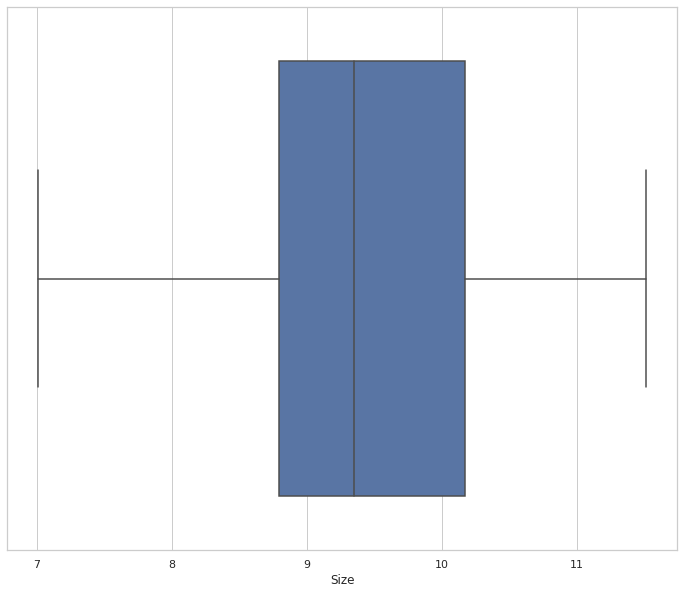

In [190]:
ax = sns.boxplot(x=df_p.loc[df_p['Size'] > 7, 'Size'])

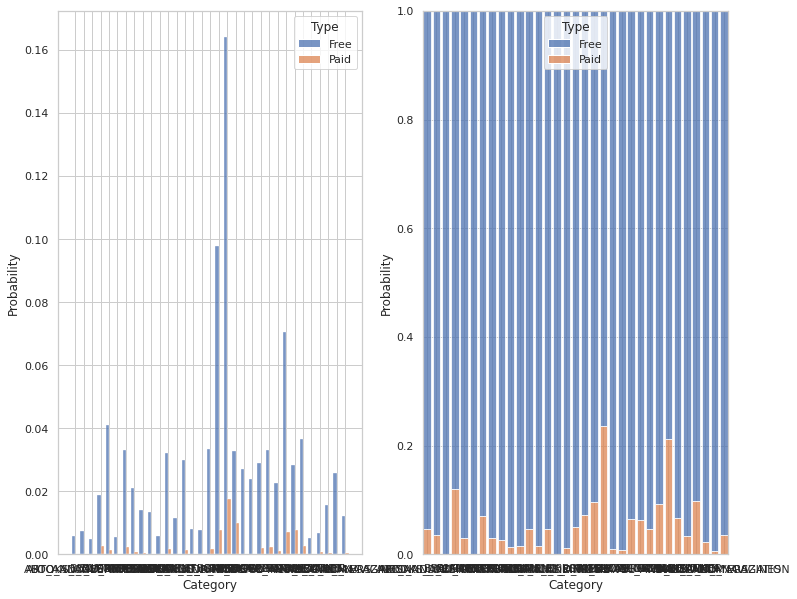

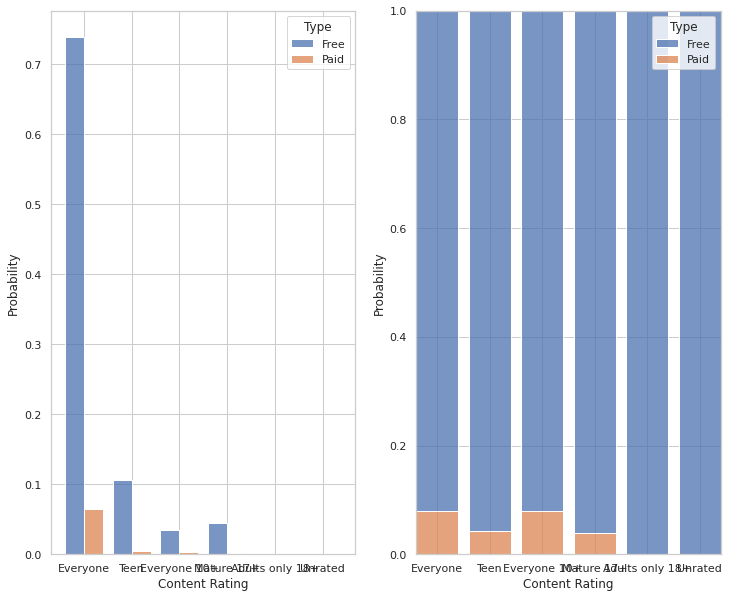

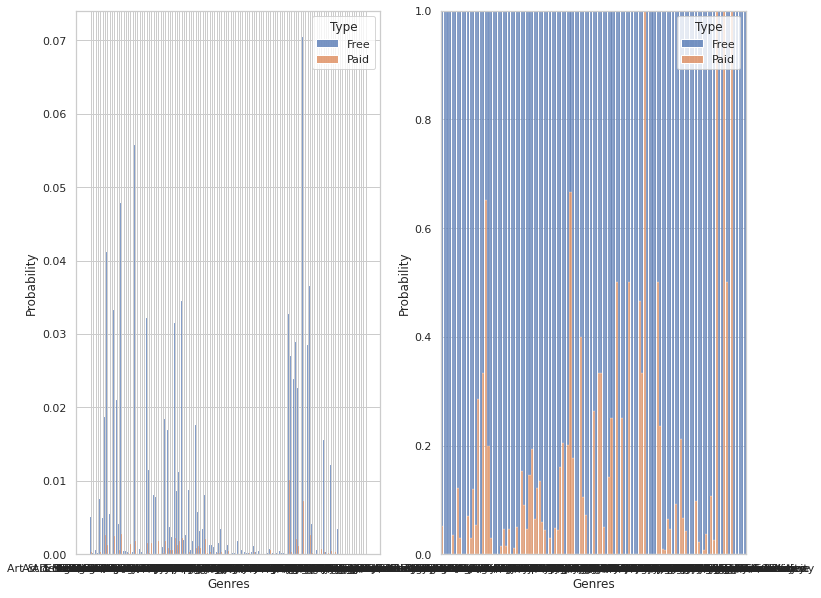

In [191]:
for col in df_p.select_dtypes('object').drop('Type', axis=1):
    fig, ax = plt.subplots(1,2)
    ax1 = sns.histplot(data=df_p, x=col, hue="Type", stat="probability", multiple="dodge", shrink=.8, ax=ax[0])
    ax2 = sns.histplot(data=df_p, x=col, hue="Type", stat="probability", multiple="fill", shrink=.8, ax=ax[1])
    fig.show()

## Model building

In [192]:
X_train, X_test, y_train, y_test = preprocess_inputs(df, rem_outliers=False, keep_genres=True)

In [193]:
X_train

,Rating,Reviews,Size,Installs,Android Ver,Last Updated Year,Last Updated Month,Last Updated Day,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,...,Genres_Tools;Education,Genres_Travel & Local,Genres_Travel & Local;Action & Adventure,Genres_Trivia,Genres_Trivia;Education,Genres_Video Players & Editors,Genres_Video Players & Editors;Creativity,Genres_Video Players & Editors;Music & Video,Genres_Weather,Genres_Word
413,0.782800,1.656200,-0.531872,1.438149,0.272171,0.548843,0.222621,1.585273,0,0,...,0,0,0,0,0,0,0,0,0,0
1145,0.168452,0.720814,-0.002520,0.929128,0.272171,0.548843,0.608068,-1.541126,0,0,...,0,0,0,0,0,0,0,0,0,0
6898,0.782800,-0.244054,-1.831682,-0.444682,-2.093191,-2.131890,-0.162825,0.230500,0,0,...,0,0,0,0,0,0,0,0,0,0
7866,-1.060242,-1.239133,-0.325124,-0.953504,0.272171,0.548843,-0.162825,-1.020059,0,0,...,0,0,0,0,0,0,0,0,0,0
1359,0.578017,0.736738,-0.002520,0.573338,0.272171,0.548843,-0.162825,-0.082140,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6321,0.373235,-0.623313,0.961207,-0.444682,0.272171,-0.344735,1.378962,1.481059,0,0,...,0,0,0,0,0,0,0,0,0,0
5264,0.373235,-1.683209,-1.217248,-2.084692,0.272171,0.548843,-0.162825,-0.915846,0,0,...,0,0,0,0,0,0,0,0,0,0
7021,0.578017,0.764215,-0.186287,0.929128,0.272171,0.548843,0.222621,0.334713,0,0,...,0,0,0,0,0,0,0,0,0,0
8104,1.601929,-1.432495,-0.177195,-1.460546,0.272171,-0.344735,0.608068,-1.332699,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
y_train

413     0
1145    0
6898    0
7866    0
1359    0
       ..
6321    0
5264    0
7021    0
8104    0
7521    0
Name: Type, Length: 7587, dtype: int64

### LinearSVC

In [195]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)

y_pred = linear_svc.predict(X_test)

print(f'Training set: {linear_svc.score(X_train, y_train)}')
print(f'Testing set: {linear_svc.score(X_test, y_test)}')
print(classification_report(y_test, y_pred))

Training set: 0.9360748649004876
Testing set: 0.9274292742927429
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3008
           1       0.56      0.16      0.25       244

    accuracy                           0.93      3252
   macro avg       0.75      0.57      0.61      3252
weighted avg       0.91      0.93      0.91      3252



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [196]:
X_train, X_test, y_train, y_test = preprocess_inputs(df, rem_outliers=True, keep_genres=True)

linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)

y_pred = linear_svc.predict(X_test)

print(f'Training set: {linear_svc.score(X_train, y_train)}')
print(f'Testing set: {linear_svc.score(X_test, y_test)}')
print(classification_report(y_test, y_pred))

Training set: 0.9340977988664821
Testing set: 0.9308118081180812
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3011
           1       0.62      0.17      0.27       241

    accuracy                           0.93      3252
   macro avg       0.78      0.58      0.62      3252
weighted avg       0.91      0.93      0.91      3252



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


### SVC

In [197]:
svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print(f'Training set: {svc.score(X_train, y_train)}')
print(f'Testing set: {svc.score(X_test, y_test)}')
print(classification_report(y_test, y_pred))

Training set: 0.9396335837616976
Testing set: 0.9320418204182042
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3011
           1       0.88      0.10      0.17       241

    accuracy                           0.93      3252
   macro avg       0.91      0.55      0.57      3252
weighted avg       0.93      0.93      0.91      3252



In [198]:
X_train, X_test, y_train, y_test = preprocess_inputs(df, rem_outliers=True, keep_genres=True)

svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print(f'Training set: {svc.score(X_train, y_train)}')
print(f'Testing set: {svc.score(X_test, y_test)}')
print(classification_report(y_test, y_pred))

Training set: 0.9406880189798339
Testing set: 0.9329643296432965
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      3016
           1       0.82      0.10      0.17       236

    accuracy                           0.93      3252
   macro avg       0.88      0.55      0.57      3252
weighted avg       0.93      0.93      0.91      3252

